# BB84 QKD Parameters Optimization

## Fiber Lengths and n_X Values
Fiber lengths are created from 0 to 200 km in 0.1 km steps, resulting in 2001 unique fiber lengths. \
$n_X$ values are used ranging from $10^6$ to $10^{10}$, creating 5 unique values. \
Form all combinations of fiber lengths and $n_X$, resulting in 2001 $\times$ 5 = 10,005 combinations, which aligns with the aim to generate a large dataset.

## Optimization Process:
For each combination of fiber length $L$ and $n_X$, The parameters $\vec{p}$ = $ [ \mu_1, \mu_2, P_{\mu_1}, P_{\mu_2}, P_X ]$ are optimized using dual_annealing, which is a global optimization algorithm. \
The objective function is wrapped to evaluate the key rate for a specific combination of fiber length and $n_X$. 

## Parallelization:
joblib’s Parallel is used to run the optimization for all combinations in parallel, with 12 threads, making the process efficient. \
tqdm-joblib is also used to track progress visually. 

## Dataset Creation:
The results of the optimization ($e_1, e_2, e_3, e_4, n_X, R, p_{opt}$) are collected into a dataset. \
This dataset is saved to a file (training_dataset.json) for training a neural network. 




## Setup

### Framework Selection:JAX
Functional Programming: Simplify scientific computation and optimization workflows. \
Smaller Footprint: Ideal if the project doesn’t leverage TensorFlow’s broader ecosystem.

##### Key Considerations
For numerically intensive workloads (e.g., optimization tasks like QKD key rate calculations), JAX excels due to its lightweight functional paradigm.

##### Conclusion
Use JAX for performance-critical, purely numerical optimization tasks with minimal dependencies on machine learning frameworks.

## Imports

In [1]:
# Import necessary libraries
import os
import sys
import time
import json
import functools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from tqdm_joblib import tqdm_joblib
from joblib import Parallel, delayed
from concurrent.futures import ProcessPoolExecutor
from collections import defaultdict
from scipy.optimize import minimize, dual_annealing, differential_evolution, Bounds

# JAX imports
import jax
import jax.numpy as jnp
from jax import grad, jit, vmap
from jax.scipy.special import logsumexp, gamma
from jax.experimental import pjit
from jax.sharding import Mesh

# SciPy imports
from math import exp, factorial

# JAX configuration for double precision
jax.config.update("jax_enable_x64", True)

# Get the notebook's directory
notebook_dir = os.getcwd()
# Add parent directory to path
project_root = os.path.dirname(notebook_dir)
sys.path.append(project_root)

/Users/daai6ga1hou2/anaconda3/envs/qkd-training_set/lib/python3.9/site-packages/tqdm_joblib/__init__.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
print(jax.devices())

[CpuDevice(id=0)]


## Experimental Parameters

In [3]:
# e_1
# Fiber lengths
Ls = jnp.linspace(1e-12, 200, 200)  # Fiber lengths in km
L_BC = Ls
e_1 = L_BC / 100
    
#e_2
P_dc_value = 6*10**-7  # Dark count probability
Y_0 = P_dc_value
# 2.7*10** -7
# P_dc = 6 * 10 ** (-7)   # given in the paper, discussed with range from 10^-8 to 10^-5
# e_2 = -jnp.log(Y_0)

# e_3
e_mis = 5 * 10 ** -3  # Misalignment error probability
# 0.026 
e_d = e_mis
e_3 = e_d * 100
e_mis = 5*1e-3 # given in the paper, discussed with range from 0 to 0.1 

# e_4
# Detected events
n_X_values = [10 ** s for s in range(4, 15)]  # Detected events
# n_X_values = jnp.array([10**s for s in range(6, 11)], dtype=jnp.int64)
N = n_X_values
e_4 = N

## Other Parameters

In [4]:
alpha = 0.2  # Attenuation coefficient (dB/km), given in the paper
eta_Bob = 0.1  # Detector efficiency, given in the paper
P_ap = 0  # After-pulse probability
f_EC = 1.16  # Error correction efficiency
# secutity error 
epsilon_sec = 1e-10 # is equal to kappa * secrecy length Kl, range around 1e-10 Scalar, as it is a single value throughout the calculations.
# correlation error
epsilon_cor = 1e-15 # given in the paper, discussed with range from 0 to 10e-10
# Dark count probability
n_event = 1  # for single photon event
# Misalignment error probability
# 4*1e-2          # given in the paper, discussed with range from 0 to 0.1
kappa = 1e-15           # given in the paper
f_EC = 1.16             # given in the paper, range around 1.1


## Optimal Paramters

In [5]:
def optimal_parameters(params):
    mu_1, mu_2, P_mu_1, P_mu_2, P_X_value = params
    mu_3 = 2e-4
    P_mu_3 = 1 - P_mu_1 - P_mu_2
    P_Z_value = 1 - P_X_value
    mu_k_values = jnp.array([mu_1, mu_2, mu_3])
    return params, mu_3, P_mu_3, P_Z_value, mu_k_values

## Functions

The calculate_factorial function provided uses the gamma function to compute the factorial of a number  n . This is mathematically correct because the gamma function  \Gamma(n+1)  is equivalent to the factorial  n!  for non-negative integers  n .

## Mathematical Background
The gamma function is defined as:
$\Gamma(x) = \int_0^\infty t^{x-1} e^{-t} \, dt$ \
For positive integers, the gamma function satisfies the relationship: \
$\Gamma(n + 1) = n!$
\
JAX does not have a built-in factorial function, but it does support the gamma function. This makes the approach valid and compatible with JAX for automatic differentiation and JIT compilation.

In [6]:
from QKD_Functions import (
calculate_factorial,
calculate_tau_n,
    calculate_eta_ch,
    calculate_eta_sys,
    calculate_D_mu_k,
    calculate_n_X_total,
    calculate_N,
    calculate_n_Z_total,
    calculate_e_mu_k,
    calculate_e_obs,
    calculate_h,
    calculate_lambda_EC,
    calculate_sqrt_term,
    calculate_tau_n,
    calculate_n_pm, 
    calculate_S_0,
    calculate_S_1,
    calculate_m_mu_k,
    calculate_m_pm,
    calculate_v_1,
    calculate_gamma,
    calculate_Phi,
    calculate_LastTwoTerm,
    calculate_l,
    calculate_R,
    experimental_parameters,
    other_parameters,
    calculate_key_rates_and_metrics,
    penalty, 
    objective,
)

In [9]:
def optimize_single_instance(input_params, bounds, alpha, eta_Bob, P_dc_value, epsilon_sec, epsilon_cor, f_EC, e_mis, P_ap, n_event, max_retries=10):
    """
    Optimize key rates for a given fiber length and n_X value using dual annealing 
    and Nelder-Mead optimization, ensuring parameters remain within bounds and retry
    if log10(key_rate) > 0.
    """
    L, n_X = input_params

    def wrapped_objective(params):
        # Negative because we minimize, but key rates need maximization
        return -objective(params, L, n_X, alpha, eta_Bob, P_dc_value, epsilon_sec, epsilon_cor, f_EC, e_mis, P_ap, n_event)[0]

    best_key_rate = float('-inf')
    best_params = None

    for attempt in range(max_retries):
        try:
            # Step 1: Perform global optimization using dual annealing
            global_result = dual_annealing(
                func=wrapped_objective,
                bounds=bounds,
                initial_temp=20,  # Reduced initial temperature
                restart_temp_ratio=1e-8,  # Adjusted if needed
                visit=2.0,  # Adjusted if needed
                accept=-15.0,
                #   x_0  # Adjusted if needed,

            )

            # Step 2: Refine results using local optimization (Nelder-Mead)
            local_result = minimize(
                fun=wrapped_objective,
                x0=global_result.x,  # Start from global optimization result
                method='Nelder-Mead',
                options={'maxiter': 10000, 'xatol': 1e-10, 'fatol': 1e-10}  # Tighter tolerances and increased maxiter
            )
            # Extract the optimized parameters and key rate
            optimized_params = local_result.x
            optimized_key_rate = -local_result.fun  # Convert back to key rate (positive)

            # Validate the optimized parameters against the bounds
            out_of_bounds = any(
                param < b[0] or param > b[1]
                for param, b in zip(optimized_params, bounds)
            )

            # Retry if key rate is abnormal (log10(key_rate) > 0)
            if np.log10(max(optimized_key_rate, 1e-10)) > 0:
                print(f"Attempt {attempt + 1}: Abnormal key rate detected (log10 > 0). Retrying...")
                continue

            if not out_of_bounds:
                # If all parameters are valid, update best results if key rate is improved
                if optimized_key_rate > best_key_rate:
                    best_key_rate = optimized_key_rate
                    best_params = optimized_params

                # Stop retrying if parameters stabilize
                if best_params is not None and np.allclose(best_params, optimized_params, atol=1e-4):
                    break
            else:
                print(f"Attempt {attempt + 1}: Parameters out of bounds. Retrying...")

        except Exception as e: 
            print(f"Attempt {attempt + 1}: Optimization error: {e}. Retrying...")

    if best_params is not None:
        return L, n_X, best_key_rate, best_params

    # If we exhaust retries, raise an error or return NaN results
    print(f"Optimization failed after {max_retries} retries.")
    return L, n_X, float('nan'), [float('nan')] * len(bounds)

In [10]:
initial_guess = [0.325684, 0.008542, 0.601268, 0.810905, 0.681594]
initial_guesses = {n_X: {} for n_X in n_X_values}  # Store last optimized p per n_X and L
bounds = [
    (4e-4, 0.9),  # mu_1 (ensure within a reasonable range)
    (2e-4, 0.5),  # mu_2 (less than mu_1)
    (1e-12, 1.0-1e-12),  # P_mu_1
    (1e-12, 1.0),  # P_mu_2 
    (1e-12, 1.0),  # P_X_value
]

In [11]:
def optimize_single_instance(input_params, bounds, alpha, eta_Bob, P_dc_value, epsilon_sec, epsilon_cor, f_EC, e_mis, P_ap, n_event, max_retries=10):
    """
    Optimize key rates for a given fiber length and n_X value using dual annealing 
    and Nelder-Mead optimization, ensuring parameters remain within bounds and retry
    if log10(key_rate) > 0.
    """
    L, n_X = input_params

    def wrapped_objective(params):
        # Negative because we minimize, but key rates need maximization
        return -objective(params, L, n_X, alpha, eta_Bob, P_dc_value, epsilon_sec, epsilon_cor, f_EC, e_mis, P_ap, n_event)[0]

    best_key_rate = float('-inf')
    best_params = None

    for attempt in range(max_retries):
        try:
            # Step 1: Perform global optimization using dual annealing
            global_result = dual_annealing(
                func=wrapped_objective,
                bounds=bounds,
                initial_temp=20,  # Reduced initial temperature
                restart_temp_ratio=1e-8,  # Adjusted if needed
                visit=2.0,  # Adjusted if needed
                accept=-15.0  # Adjusted if needed
            )

            # Step 2: Refine results using local optimization (Nelder-Mead)
            local_result = minimize(
                fun=wrapped_objective,
                x0=global_result.x,  # Start from global optimization result
                method='Nelder-Mead',
                options={'maxiter': 10000, 'xatol': 1e-10, 'fatol': 1e-10}  # Tighter tolerances and increased maxiter
            )
            # Extract the optimized parameters and key rate
            optimized_params = local_result.x
            optimized_key_rate = -local_result.fun  # Convert back to key rate (positive)

            # Validate the optimized parameters against the bounds
            out_of_bounds = any(
                param < b[0] or param > b[1]
                for param, b in zip(optimized_params, bounds)
            )

            # Retry if key rate is abnormal (log10(key_rate) > 0)
            if np.log10(max(optimized_key_rate, 1e-10)) > 0:
                print(f"Attempt {attempt + 1}: Abnormal key rate detected (log10 > 0). Retrying...")
                continue

            if not out_of_bounds:
                # If all parameters are valid, update best results if key rate is improved
                if optimized_key_rate > best_key_rate:
                    best_key_rate = optimized_key_rate
                    best_params = optimized_params

                # Stop retrying if parameters stabilize
                if best_params is not None and np.allclose(best_params, optimized_params, atol=1e-4):
                    break
            else:
                print(f"Attempt {attempt + 1}: Parameters out of bounds. Retrying...")

        except Exception as e: 
            print(f"Attempt {attempt + 1}: Optimization error: {e}. Retrying...")

    if best_params is not None:
        return L, n_X, best_key_rate, best_params

    # If we exhaust retries, raise an error or return NaN results
    print(f"Optimization failed after {max_retries} retries.")
    return L, n_X, float('nan'), [float('nan')] * len(bounds)

In [12]:
# Define input parameters for a single instance
single_input = (Ls[0], n_X_values[0])  # Example: first fiber length and first n_X value

# Measure start time
start_time = time.time()

# Run the optimization for the single instance
L, n_X, optimized_key_rate, optimized_params = optimize_single_instance(
    single_input, bounds, alpha, eta_Bob, P_dc_value, epsilon_sec, epsilon_cor, f_EC, e_mis, P_ap, n_event
)

# Measure end time
end_time = time.time()

# Output the results with parameter names
parameter_names = ["mu_1", "mu_2", "P_mu_1", "P_mu_2", "P_X_value"]
optimized_parameters = {name: value for name, value in zip(parameter_names, optimized_params)}

print(f"Optimization for a single instance took {end_time - start_time:.2f} seconds.")
print(f"Fiber Length: {L} km, Detected Events (n_X): {n_X}")
print(f"Optimized Key Rate: {optimized_key_rate:.3e}")
print("Optimized Parameters:")
for name, value in optimized_parameters.items():
    print(f"  {name}: {value:.6f}")

Attempt 1: Abnormal key rate detected (log10 > 0). Retrying...
Optimization for a single instance took 13.48 seconds.
Fiber Length: 1e-12 km, Detected Events (n_X): 10000
Optimized Key Rate: 5.054e-04
Optimized Parameters:
  mu_1: 0.644984
  mu_2: 0.155052
  P_mu_1: 0.052971
  P_mu_2: 0.616526
  P_X_value: 0.423632


In [13]:
def generate_comprehensive_dataset(Ls, n_X_values, bounds, alpha, eta_Bob, P_dc_value, epsilon_sec, epsilon_cor, f_EC, e_mis, P_ap, n_event, n_jobs=12):
    """
    Generate a comprehensive dataset using parallel processing
    n_jobs: number of CPU cores to use (default=12)
    """
    # Create all combinations of L and n_X
    combinations = [(L, float(n_X)) for L in Ls for n_X in n_X_values]
    
    # Initialize dictionary to store results
    categorized_dataset = {float(n_X): [] for n_X in n_X_values}
    
    def process_single_combination(combo):
        """Process a single (L, n_X) combination"""
        L, n_X_float = combo
        
        # Optimize parameters for this combination
        result = optimize_single_instance(
            (L, n_X_float), bounds, alpha, eta_Bob, P_dc_value, 
            epsilon_sec, epsilon_cor, f_EC, e_mis, P_ap, n_event
        )
        
        if result is None or result[2] <= 0:  # Skip if optimization failed or key rate is invalid
            return None
            
        L_val, _, penalized_key_rate, optimized_params = result
        mu_1, mu_2, P_mu_1, P_mu_2, P_X_value = optimized_params
        
        # Compute normalized parameters
        return {
            "n_X": n_X_float,
            "fiber_length": float(L_val),
            "e_1": float(L_val / 100),
            "e_2": float(-jnp.log10(P_dc_value)),
            "e_3": float(e_mis * 100),
            "e_4": float(jnp.log10(n_X_float)),
            "key_rate": float(max(penalized_key_rate, 1e-10)),
            "optimized_params": {
                "mu_1": float(mu_1),
                "mu_2": float(mu_2),
                "P_mu_1": float(P_mu_1),
                "P_mu_2": float(P_mu_2),
                "P_X_value": float(P_X_value)
            }
        }
    
    print(f"Starting parallel optimization with {n_jobs} cores...")
    print(f"Total combinations to process: {len(combinations)}")
    
    # Run parallel processing with progress bar
    with tqdm_joblib(tqdm(desc="Generating Dataset", total=len(combinations))):
        results = Parallel(n_jobs=n_jobs)(
            delayed(process_single_combination)(combo) 
            for combo in combinations
        )
    
    # Organize results into categorized dataset
    for result in results:
        if result is not None:  # Skip failed optimizations
            n_X = result.pop("n_X")  # Remove and get n_X
            categorized_dataset[n_X].append(result)
    
    # Sort entries within each n_X category by fiber length
    for n_X in categorized_dataset:
        categorized_dataset[n_X].sort(key=lambda x: x['fiber_length'])
    
    # Save the dataset with timestamp
    timestamp = time.strftime("%Y%m%d_%H%M%S")
    filename = f'qkd_dataset_comprehensive_100_{timestamp}.json'
    with open(filename, 'w') as f:
        json.dump(categorized_dataset, f, indent=2)
    
    print(f"\nDataset saved as: {filename}")
    
    # Print statistics
    print("\nDataset Statistics:")
    for n_X in sorted(categorized_dataset.keys()):
        print(f"n_X = {n_X:.0e}: {len(categorized_dataset[n_X])} data points")
    
    return categorized_dataset

# Usage
Ls = jnp.linspace(0, 200, 1000)  # 1000 points from 5 to 200 km
n_X_values = [10**s for s in range(4, 10)]  # n_X from 10^4 to 10^14

# Generate the comprehensive dataset with parallel processing
dataset = generate_comprehensive_dataset(
    Ls, n_X_values, bounds, alpha, eta_Bob, P_dc_value, 
    epsilon_sec, epsilon_cor, f_EC, e_mis, P_ap, n_event,
    n_jobs=12  # Use 12 CPU cores
)

Starting parallel optimization with 12 cores...
Total combinations to process: 6000


Generating Dataset:   0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

/Users/daai6ga1hou2/anaconda3/envs/qkd-training_set/lib/python3.9/site-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


Attempt 1: Abnormal key rate detected (log10 > 0). Retrying...
Attempt 1: Abnormal key rate detected (log10 > 0). Retrying...
Attempt 1: Parameters out of bounds. Retrying...
Attempt 2: Abnormal key rate detected (log10 > 0). Retrying...
Attempt 1: Abnormal key rate detected (log10 > 0). Retrying...
Attempt 1: Abnormal key rate detected (log10 > 0). Retrying...
Attempt 1: Abnormal key rate detected (log10 > 0). Retrying...
Attempt 1: Abnormal key rate detected (log10 > 0). Retrying...
Attempt 1: Abnormal key rate detected (log10 > 0). Retrying...
Attempt 1: Abnormal key rate detected (log10 > 0). Retrying...
Attempt 1: Abnormal key rate detected (log10 > 0). Retrying...
Attempt 1: Parameters out of bounds. Retrying...
Attempt 1: Abnormal key rate detected (log10 > 0). Retrying...
Attempt 2: Abnormal key rate detected (log10 > 0). Retrying...
Attempt 1: Abnormal key rate detected (log10 > 0). Retrying...
Attempt 1: Abnormal key rate detected (log10 > 0). Retrying...
Attempt 3: Abnormal 

/Users/daai6ga1hou2/anaconda3/envs/qkd-training_set/lib/python3.9/site-packages/scipy/optimize/_optimize.py:836: RuntimeWarning: invalid value encountered in subtract
  np.max(np.abs(fsim[0] - fsim[1:])) <= fatol):


Attempt 2: Parameters out of bounds. Retrying...
Attempt 1: Parameters out of bounds. Retrying...
Attempt 3: Parameters out of bounds. Retrying...
Attempt 7: Parameters out of bounds. Retrying...
Attempt 2: Parameters out of bounds. Retrying...
Attempt 4: Parameters out of bounds. Retrying...
Attempt 8: Parameters out of bounds. Retrying...
Attempt 1: Parameters out of bounds. Retrying...
Attempt 5: Parameters out of bounds. Retrying...
Attempt 9: Parameters out of bounds. Retrying...
Attempt 6: Parameters out of bounds. Retrying...
Attempt 10: Parameters out of bounds. Retrying...
Optimization failed after 10 retries.
Attempt 8: Abnormal key rate detected (log10 > 0). Retrying...
Attempt 1: Parameters out of bounds. Retrying...
Attempt 9: Parameters out of bounds. Retrying...
Attempt 7: Parameters out of bounds. Retrying...
Attempt 8: Parameters out of bounds. Retrying...
Attempt 6: Parameters out of bounds. Retrying...
Attempt 4: Parameters out of bounds. Retrying...
Attempt 5: Param

/Users/daai6ga1hou2/anaconda3/envs/qkd-training_set/lib/python3.9/site-packages/scipy/optimize/_optimize.py:839: RuntimeWarning: overflow encountered in reduce
  xbar = np.add.reduce(sim[:-1], 0) / N
/Users/daai6ga1hou2/Documents/GitHub/QKD_KeyRate_ParameterOptimization/Optimization/with_retry/QKD_Functions.py:1714: RuntimeWarning: invalid value encountered in scalar add
  penalty_sum = jnp.where(jnp.abs(P_mu_1 + P_mu_2 + P_mu_3 - 1) < 1e-6, 0.0, 1e6)


Attempt 7: Abnormal key rate detected (log10 > 0). Retrying...
Attempt 3: Parameters out of bounds. Retrying...
Attempt 6: Parameters out of bounds. Retrying...
Attempt 2: Abnormal key rate detected (log10 > 0). Retrying...
Attempt 8: Parameters out of bounds. Retrying...
Attempt 4: Parameters out of bounds. Retrying...
Attempt 8: Parameters out of bounds. Retrying...
Attempt 3: Parameters out of bounds. Retrying...
Optimization failed after 10 retries.
Attempt 9: Parameters out of bounds. Retrying...
Attempt 4: Parameters out of bounds. Retrying...
Attempt 5: Abnormal key rate detected (log10 > 0). Retrying...
Attempt 10: Parameters out of bounds. Retrying...
Optimization failed after 10 retries.
Attempt 9: Abnormal key rate detected (log10 > 0). Retrying...
Attempt 1: Parameters out of bounds. Retrying...
Attempt 7: Parameters out of bounds. Retrying...
Attempt 9: Abnormal key rate detected (log10 > 0). Retrying...
Attempt 5: Parameters out of bounds. Retrying...
Attempt 6: Parameter

/Users/daai6ga1hou2/anaconda3/envs/qkd-training_set/lib/python3.9/site-packages/scipy/optimize/_optimize.py:839: RuntimeWarning: overflow encountered in reduce
  xbar = np.add.reduce(sim[:-1], 0) / N
/Users/daai6ga1hou2/Documents/GitHub/QKD_KeyRate_ParameterOptimization/Optimization/with_retry/QKD_Functions.py:1714: RuntimeWarning: invalid value encountered in scalar add
  penalty_sum = jnp.where(jnp.abs(P_mu_1 + P_mu_2 + P_mu_3 - 1) < 1e-6, 0.0, 1e6)


Attempt 9: Abnormal key rate detected (log10 > 0). Retrying...
Attempt 1: Parameters out of bounds. Retrying...
Attempt 4: Parameters out of bounds. Retrying...
Attempt 1: Parameters out of bounds. Retrying...
Attempt 2: Parameters out of bounds. Retrying...
Attempt 5: Parameters out of bounds. Retrying...
Attempt 2: Parameters out of bounds. Retrying...
Attempt 4: Abnormal key rate detected (log10 > 0). Retrying...
Attempt 6: Parameters out of bounds. Retrying...
Attempt 1: Parameters out of bounds. Retrying...
Attempt 3: Abnormal key rate detected (log10 > 0). Retrying...
Attempt 3: Parameters out of bounds. Retrying...
Attempt 4: Parameters out of bounds. Retrying...
Attempt 1: Parameters out of bounds. Retrying...
Attempt 1: Abnormal key rate detected (log10 > 0). Retrying...
Attempt 2: Parameters out of bounds. Retrying...
Attempt 4: Parameters out of bounds. Retrying...
Attempt 5: Parameters out of bounds. Retrying...
Attempt 2: Parameters out of bounds. Retrying...
Attempt 10: P

/Users/daai6ga1hou2/anaconda3/envs/qkd-training_set/lib/python3.9/site-packages/scipy/optimize/_optimize.py:836: RuntimeWarning: invalid value encountered in subtract
  np.max(np.abs(fsim[0] - fsim[1:])) <= fatol):


Attempt 1: Parameters out of bounds. Retrying...
Attempt 1: Parameters out of bounds. Retrying...
Attempt 8: Parameters out of bounds. Retrying...
Attempt 6: Parameters out of bounds. Retrying...
Attempt 1: Parameters out of bounds. Retrying...
Attempt 6: Parameters out of bounds. Retrying...
Attempt 4: Parameters out of bounds. Retrying...
Attempt 2: Parameters out of bounds. Retrying...
Attempt 7: Parameters out of bounds. Retrying...
Attempt 2: Parameters out of bounds. Retrying...
Attempt 7: Parameters out of bounds. Retrying...
Attempt 3: Parameters out of bounds. Retrying...
Attempt 8: Parameters out of bounds. Retrying...
Attempt 1: Parameters out of bounds. Retrying...
Attempt 4: Parameters out of bounds. Retrying...
Attempt 9: Parameters out of bounds. Retrying...
Attempt 5: Parameters out of bounds. Retrying...
Attempt 3: Abnormal key rate detected (log10 > 0). Retrying...
Attempt 2: Abnormal key rate detected (log10 > 0). Retrying...
Attempt 5: Parameters out of bounds. Retr


Plotting results for n_X = 1e+04


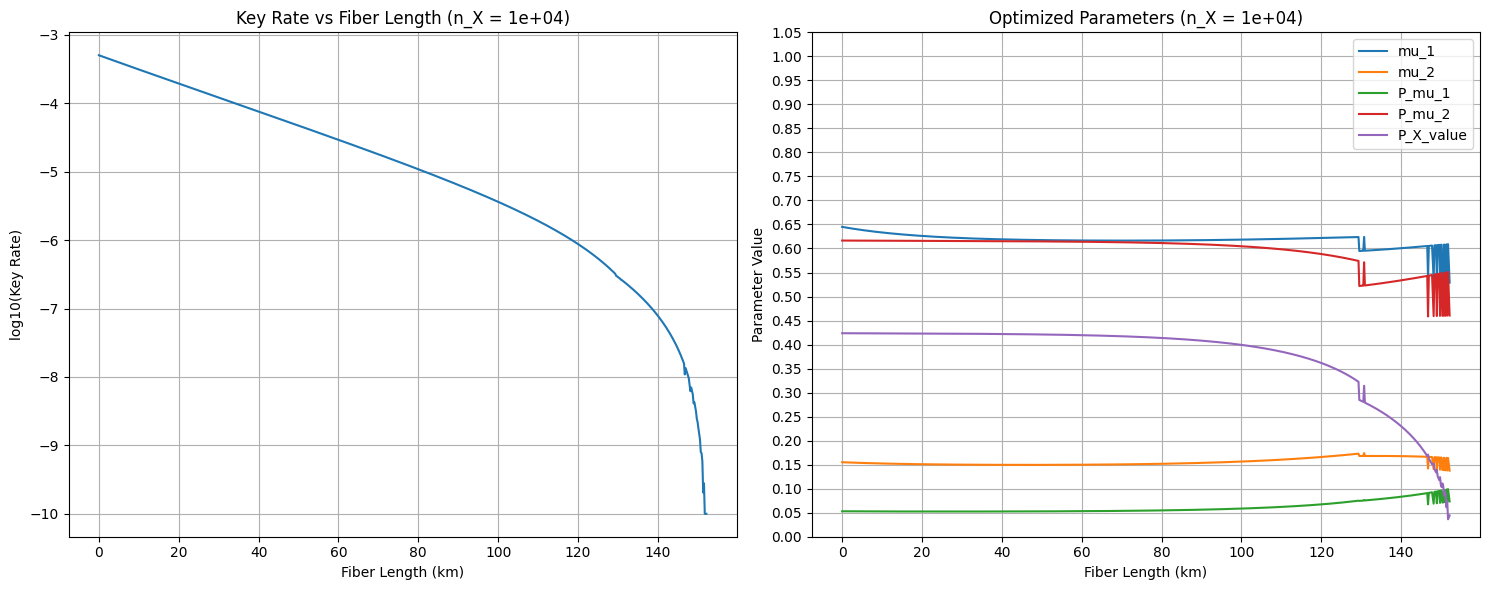


Plotting results for n_X = 1e+05


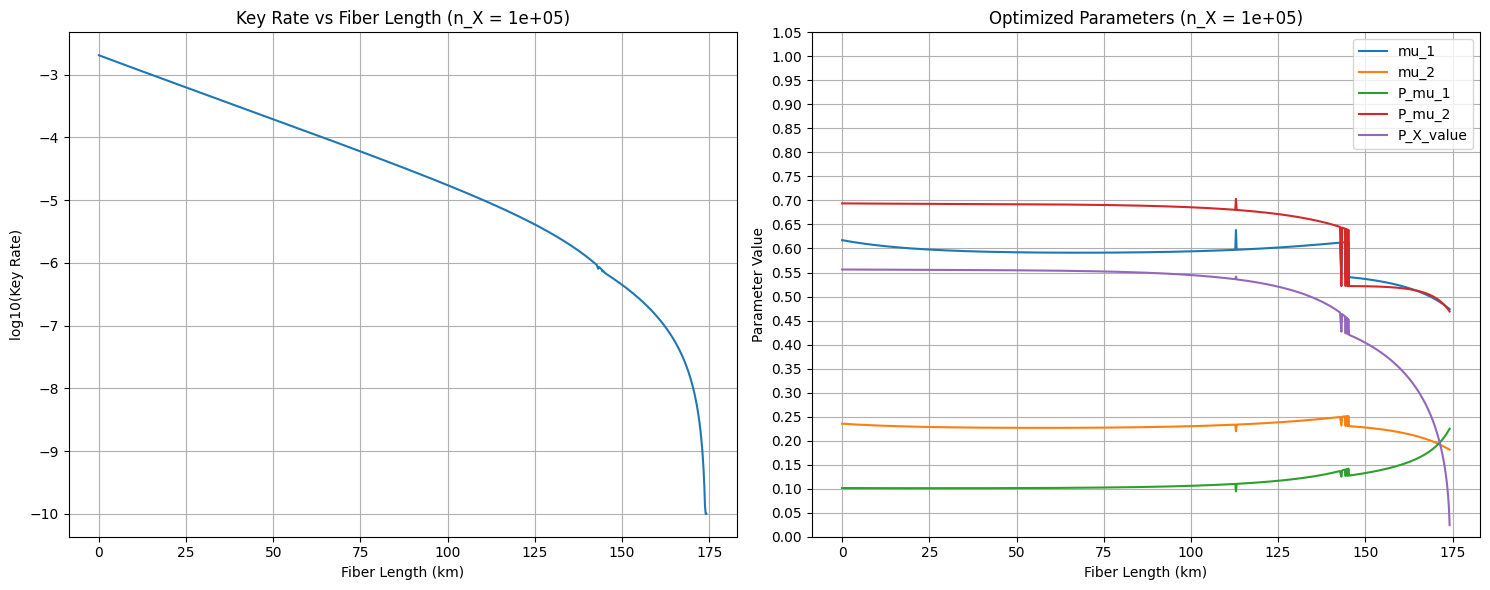


Plotting results for n_X = 1e+06


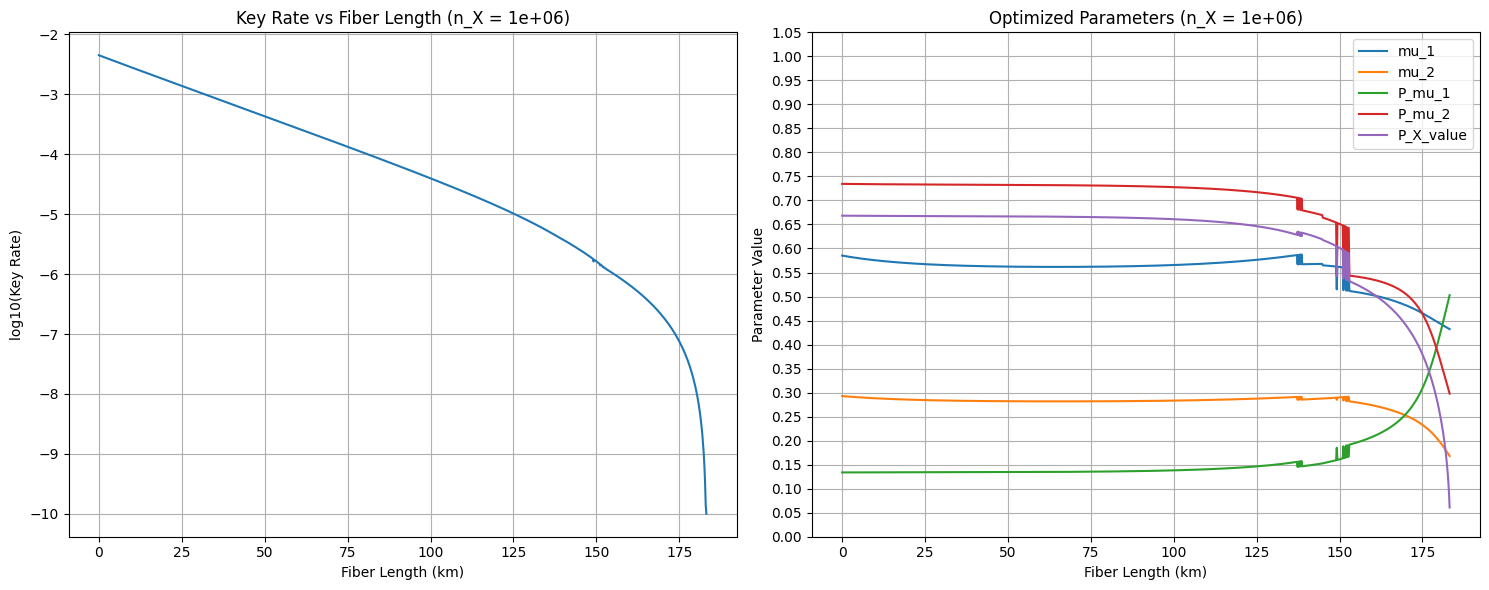


Plotting results for n_X = 1e+07


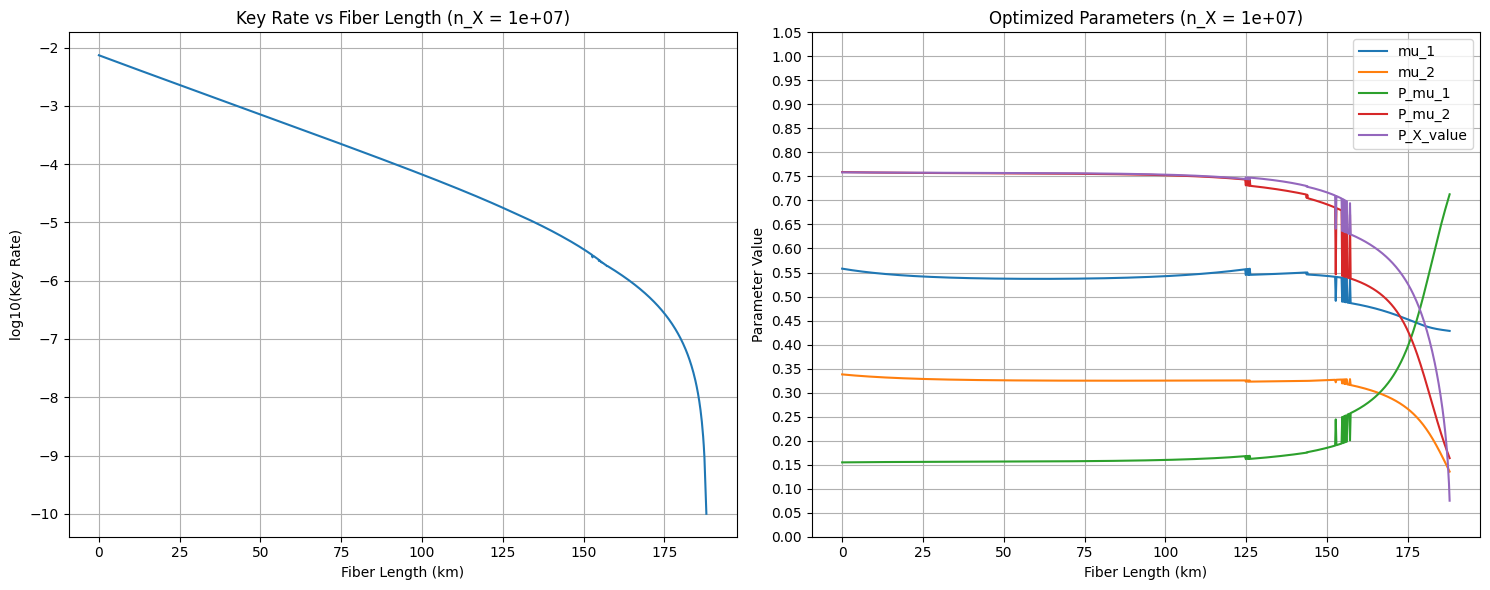


Plotting results for n_X = 1e+08


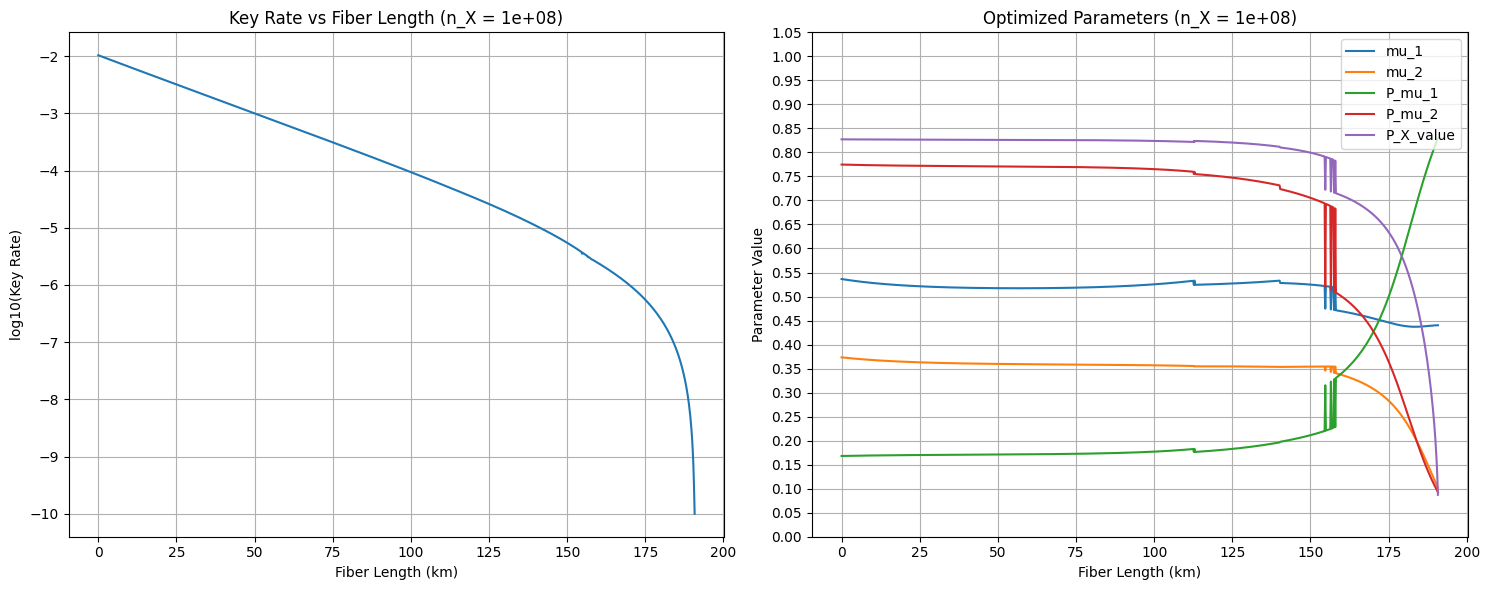


Plotting results for n_X = 1e+09


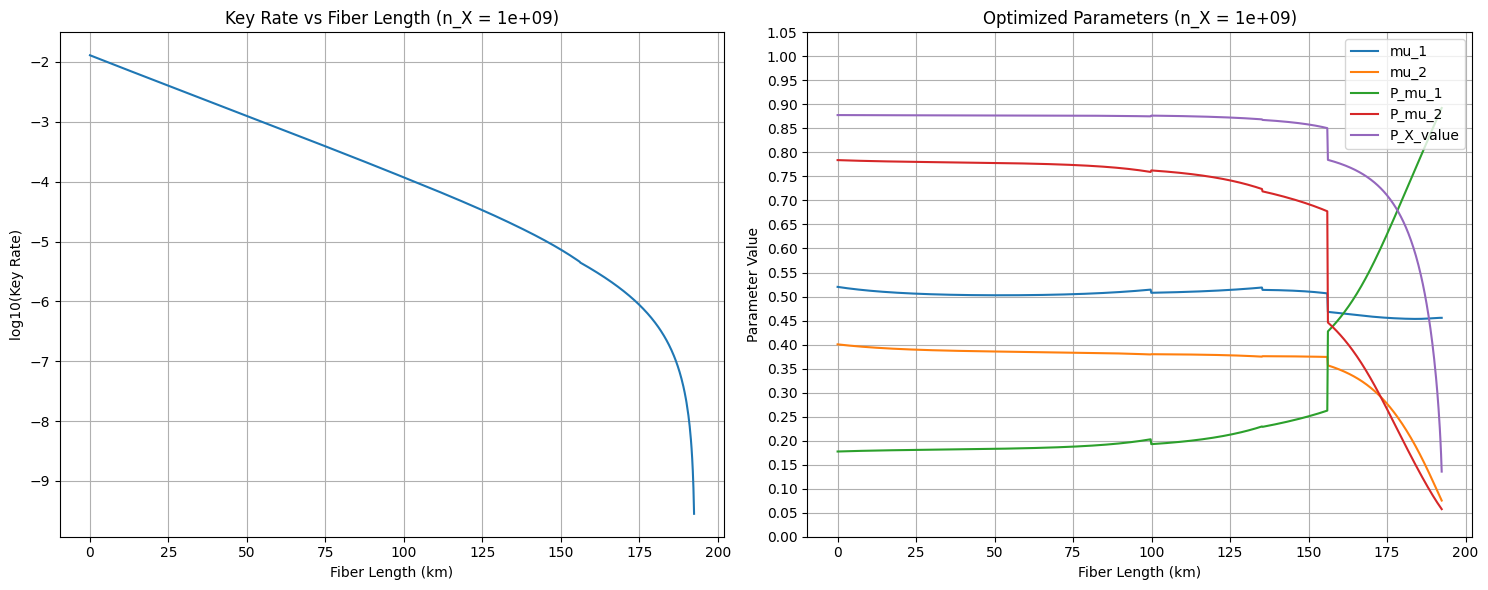


Plotting results for n_X = 1e+10
No data found for n_X = 10000000000


In [23]:
# Step 2: Load and Plot Dataset
def plot_for_nx(data, target_nx):
    """
    Plot results for a specific n_X value
    """
    # Convert target_nx to string for dictionary key
    nx_key = str(float(target_nx))
    
    if nx_key not in data:
        
        print(f"No data found for n_X = {target_nx}")
        return
        
    filtered_data = data[nx_key]
    
    if not filtered_data:
        print(f"No valid results for n_X = {target_nx}")
        return
    
    # Extract data
    fiber_lengths = [entry["fiber_length"] for entry in filtered_data]
    key_rates = [entry["key_rate"] for entry in filtered_data]
    
    # Create figure
    plt.figure(figsize=(15, 6))
    
    # Plot key rates
    plt.subplot(1, 2, 1)
    plt.plot(fiber_lengths, np.log10([max(kr, 1e-30) for kr in key_rates]))
    plt.xlabel("Fiber Length (km)")
    plt.ylabel("log10(Key Rate)")
    plt.title(f"Key Rate vs Fiber Length (n_X = {target_nx:.0e})")
    plt.grid(True)
    
    # Plot parameters
    plt.subplot(1, 2, 2)
    params = ["mu_1", "mu_2", "P_mu_1", "P_mu_2", "P_X_value"]
    for param in params:
        values = [entry["optimized_params"][param] for entry in filtered_data]
        plt.plot(fiber_lengths, values, label=param)
    
    plt.xlabel("Fiber Length (km)")
    plt.ylabel("Parameter Value")
    plt.title(f"Optimized Parameters (n_X = {target_nx:.0e})")
    plt.legend()
    
    # Set y-axis limits and ticks
    plt.ylim(0.0, 1.0)
    plt.yticks(np.arange(0.0, 1.1, 0.05))
    plt.grid(True)
    
    plt.tight_layout()
    plt.savefig(f"qkd_results_nx_{target_nx:.0e}.png", dpi=300, bbox_inches="tight")
    plt.show()

# Load the dataset
with open("qkd_dataset_comprehensive_100_20250131_163400.json", 'r') as f:
    dataset = json.load(f)

# Plot results for each n_X value
for nx in [10**s for s in range(4, 11, 1)]:
    print(f"\nPlotting results for n_X = {nx:.0e}")
    plot_for_nx(dataset, nx)


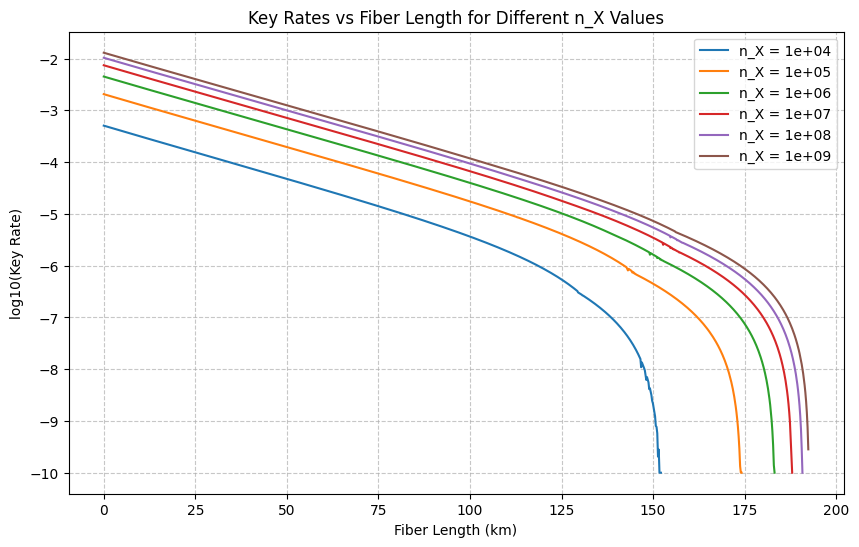

In [19]:
import json
import numpy as np
import matplotlib.pyplot as plt

# Load the dataset
with open("qkd_dataset_comprehensive_100_20250131_163400.json", 'r') as f:
    dataset = json.load(f)

def plot_all_key_rates(dataset):
    plt.figure(figsize=(10, 6))
    
    # Use a colormap for different n_X values
    cmap = plt.cm.tab10  # You can choose other colormaps like 'tab20', 'viridis', etc.
    nx_values = sorted([float(nx) for nx in dataset.keys()])
    num_colors = len(nx_values)
    
    for i, nx in enumerate(nx_values):
        nx_key = str(float(nx))
        data = dataset[nx_key]
        
        if data:
            # Extract and sort by fiber length
            fiber_lengths = [entry["fiber_length"] for entry in data]
            key_rates = [entry["key_rate"] for entry in data]
            
            # Sort data points by fiber length
            sorted_indices = np.argsort(fiber_lengths)
            sorted_lengths = [fiber_lengths[i] for i in sorted_indices]
            sorted_rates = [key_rates[i] for i in sorted_indices]
            
            # Plot with scientific notation in legend
            plt.plot(sorted_lengths, 
                    np.log10([max(kr, 1e-30) for kr in sorted_rates]), 
                    color=cmap(i % num_colors),
                    label=f'n_X = {nx:.0e}')
    
    plt.xlabel("Fiber Length (km)")
    plt.ylabel("log10(Key Rate)")
    plt.title("Key Rates vs Fiber Length for Different n_X Values")
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()
    
    # Save the figure
    plt.savefig("all_key_rates.png", dpi=300, bbox_inches="tight")
    plt.show()

# Create the plot
plot_all_key_rates(dataset)